In [1]:
!bash get_datasets.sh

# Softmax exercise

You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from utils.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `utils/classifiers/softmax.py`.


$\color{Orange}{\textit Task:}$ *First implement the naive softmax loss function with nested loops. Open the file `utils/classifiers/softmax.py` and implement the `softmax_loss_naive` function. Skip the grad implementation for now.*

In [40]:
from utils.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0000001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.302602
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.

$\color{blue}{\textit Your Answer:}$ loss of one element is $-\log \left(\frac{e^{f_y}}{\sum_{i=1}^{10} e^{f_i}}\right)$. Since $W \sim N(0, 0.01^2)$, $W$ is mostly within $(-0.03, 0.03)$, thux $f_i$ is a sum of 3073 almost independent products with variation close to 1. The smaller variation of W the smaller variation of each term will be. This means that all $f_i$ are close to each other, so loss term can be approximated as $=log(\frac{1}{\sum_{i=0}^10 1})=-log(0.1)$. Averaging over minibatch we get the coarse estimate of the general loss


$\color{Orange}{\textit Task:}$ *Complete the implementation of `softmax_loss_naive` and implement a (naive) version of the gradient that uses nested loops.*

In [21]:
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from utils.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# Do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -1.038139 analytic: -1.038139, relative error: 3.585250e-09
numerical: 1.142460 analytic: 1.142460, relative error: 3.630212e-09
numerical: 2.244784 analytic: 2.244784, relative error: 5.191901e-09
numerical: -0.765330 analytic: -0.765329, relative error: 8.741565e-08
numerical: 0.177245 analytic: 0.177245, relative error: 4.571780e-08
numerical: 0.363322 analytic: 0.363322, relative error: 1.846988e-08
numerical: -2.309188 analytic: -2.309188, relative error: 2.868708e-08
numerical: 2.663564 analytic: 2.663564, relative error: 2.772581e-09
numerical: -0.628890 analytic: -0.628890, relative error: 9.980017e-08
numerical: 0.797264 analytic: 0.797264, relative error: 1.073543e-08
numerical: -0.862875 analytic: -0.862875, relative error: 6.642269e-09
numerical: -3.120032 analytic: -3.120032, relative error: 4.205255e-10
numerical: -1.046858 analytic: -1.046858, relative error: 1.615482e-08
numerical: 1.286282 analytic: 1.286282, relative error: 2.729009e-08
numerical: 3.797674 

$\color{Orange}{\textit Task:}$ *Now that we have a naive implementation of the softmax loss function and its gradient, implement a vectorized version in `softmax_loss_vectorized`. The two versions should compute the same results, but the vectorized version should be much faster.*

In [28]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from utils.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.373536e+00 computed in 0.105766s
vectorized loss: 2.373536e+00 computed in 0.010050s
Loss difference: 0.000000
Gradient difference: 0.000000


$\color{Orange}{\textit Task:}$ *Use the validation set to tune hyperparameters (**regularization strength** and **learning rate**). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over **0.35** on the validation set.*

In [37]:
from utils.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# save the best trained softmax classifer in best_softmax.                     #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-8, 1e-7, 5e-7]
regularization_strengths = [1.5e4, 2.5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
    for reg in regularization_strengths:
        print("\n===================")
        print(f"lr: {lr}, reg: {reg}")
        classifier = Softmax()
        classifier.train(X_train, y_train, learning_rate=lr, reg=reg, num_iters=2000, verbose=True)

        y_train_pred = classifier.predict(X_train)
        acc_train = (y_train_pred == y_train).mean()

        y_val_pred = classifier.predict(X_val)
        acc_val = (y_val_pred == y_val).mean()

        results[(lr, reg)] = acc_train, acc_val
        if acc_val > best_val:
            best_val = acc_val
            best_softmax = classifier

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)


lr: 1e-08, reg: 15000.0
iteration 0 / 2000: loss 461.609417
iteration 100 / 2000: loss 434.856227
iteration 200 / 2000: loss 409.738057
iteration 300 / 2000: loss 385.543309
iteration 400 / 2000: loss 363.136589
iteration 500 / 2000: loss 341.996163
iteration 600 / 2000: loss 322.060710
iteration 700 / 2000: loss 303.187984
iteration 800 / 2000: loss 285.494159
iteration 900 / 2000: loss 269.081272
iteration 1000 / 2000: loss 253.251066
iteration 1100 / 2000: loss 238.545881
iteration 1200 / 2000: loss 224.731641
iteration 1300 / 2000: loss 211.404380
iteration 1400 / 2000: loss 199.308777
iteration 1500 / 2000: loss 187.951913
iteration 1600 / 2000: loss 177.114515
iteration 1700 / 2000: loss 166.706786
iteration 1800 / 2000: loss 157.140816
iteration 1900 / 2000: loss 148.017061

lr: 1e-08, reg: 25000.0
iteration 0 / 2000: loss 772.323215
iteration 100 / 2000: loss 698.880279
iteration 200 / 2000: loss 632.275092
iteration 300 / 2000: loss 571.988959
iteration 400 / 2000: loss 517.5

In [38]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.364000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$ Yes


$\color{blue}{\textit Your Explanation:}$ We can add such a point that the class predicted for it by SVM is correct and larger than others scores more by a delta. Then SVM loss doesn't change and softmax loss easily can be changed via small shifts.  



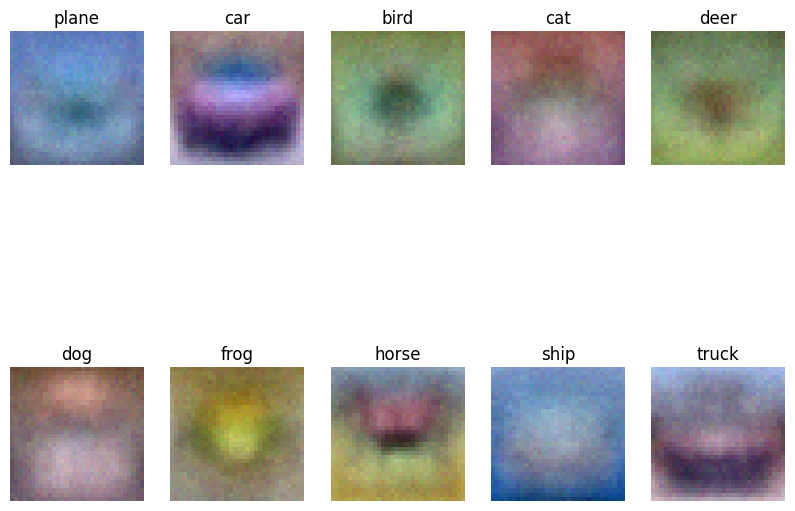

In [39]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])